In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [2]:
dataset = pd.read_csv('./data/car_evaluation.csv')

In [3]:
print(dataset.head())
print()
print(dataset.info())
print()
print(dataset.describe())

   price  maint doors persons lug_capacity safety output
0  vhigh  vhigh     2       2        small    low  unacc
1  vhigh  vhigh     2       2        small    med  unacc
2  vhigh  vhigh     2       2        small   high  unacc
3  vhigh  vhigh     2       2          med    low  unacc
4  vhigh  vhigh     2       2          med    med  unacc

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB
None

        price  maint doors persons lug_capacity safety output
count    1728   1728  1728    1728         1728   1728   1728
un

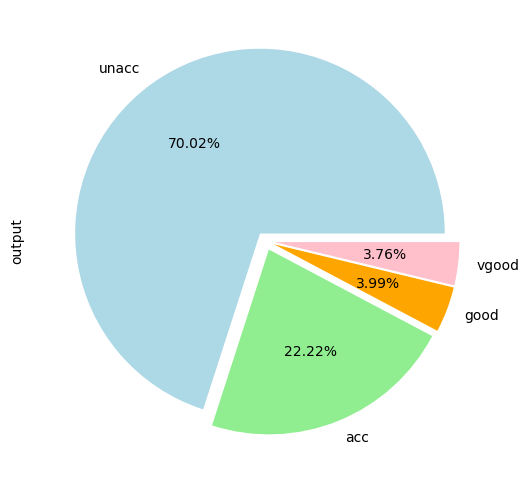

In [4]:
# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 8
# fig_size[1] = 6
# plt.rcParams["figure.figsize"] = fig_size

plt.figure(figsize=(8 ,6))
dataset.output.value_counts().plot(kind='pie', 
                                   autopct='%0.02f%%', 
                                   colors=['lightblue', 'lightgreen', 'orange', 'pink'],
                                   explode=(0.05, 0.05, 0.05, 0.05))
plt.show()

In [5]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

In [6]:
# print(dataset.head())
# print()
# print(dataset.info())
# print()
# print(dataset.describe())

In [7]:
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)

In [8]:
print(f"price.shape: {price.shape}")
print()
print(f"categorical_data.shape: {categorical_data.shape}")
print()
print(pd.DataFrame(categorical_data).head())
print()
print(pd.DataFrame(categorical_data).info())
print()
print(pd.DataFrame(categorical_data).describe())

price.shape: (1728,)

categorical_data.shape: (1728, 6)

   0  1  2  3  4  5
0  3  3  0  0  2  1
1  3  3  0  0  2  2
2  3  3  0  0  2  0
3  3  3  0  0  1  1
4  3  3  0  0  1  2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       1728 non-null   int8 
 1   1       1728 non-null   int8 
 2   2       1728 non-null   int8 
 3   3       1728 non-null   int8 
 4   4       1728 non-null   int8 
 5   5       1728 non-null   int8 
dtypes: int8(6)
memory usage: 10.2 KB
None

                 0            1            2            3            4  \
count  1728.000000  1728.000000  1728.000000  1728.000000  1728.000000   
mean      1.500000     1.500000     1.500000     1.000000     1.000000   
std       1.118358     1.118358     1.118358     0.816733     0.816733   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.750000    

In [9]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
print(categorical_data[:5])

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2]])


In [10]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(f"categorical_data.shape: {categorical_data.shape}")
print(f"outputs.shape: {outputs.shape}")

categorical_data.shape: torch.Size([1728, 6])
outputs.shape: torch.Size([6912])


In [11]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1) // 2)) for col_size in categorical_column_sizes]

# 임베딩 크기에 대한 정확한 규칙은 없지만, 칼럼의 고유 값 수를 2로 나누는 것을 많이 사용합니다.
# (모든 범주형 칼럼의 고유 값 수, 차원의 크기)
# TODO 임베딩과 차원의 크기
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [12]:
total_records = 1728
test_records = int(total_records * 0.2)

categorical_train_data = categorical_data[:(total_records - test_records)]
categorical_test_data = categorical_data[(total_records - test_records):total_records]
train_outputs = outputs[:(total_records - test_records)]
test_outputs = outputs[(total_records - test_records):total_records]

In [13]:
print(f"categorical train: {len(categorical_train_data)}")
print(f"outputs train    : {len(train_outputs)}")
print(f"categorical test : {len(categorical_test_data)}")
print(f"outputs test     : {len(test_outputs)}")

categorical train: 1383
outputs train    : 1383
categorical test : 345
outputs test     : 345


In [14]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        # TODO layer 만드는 방법
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols 

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [15]:
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [16]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
if torch.backends.mps.is_available():
    print("device: mps")
    device = torch.device('mps')
else:
    print("device: cpu")
    device = torch.device('cpu')

# device = torch.device('cpu')

device: mps


In [18]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.2f}')

epoch:   1 loss: 1.62087238
epoch:  26 loss: 1.41515505
epoch:  51 loss: 1.32406735
epoch:  76 loss: 1.19980836
epoch: 101 loss: 1.09890234
epoch: 126 loss: 0.95590234
epoch: 151 loss: 0.81694007
epoch: 176 loss: 0.75883973
epoch: 201 loss: 0.69444460
epoch: 226 loss: 0.66604501
epoch: 251 loss: 0.63364279
epoch: 276 loss: 0.62312573
epoch: 301 loss: 0.61731142
epoch: 326 loss: 0.59438252
epoch: 351 loss: 0.58047885
epoch: 376 loss: 0.58469033
epoch: 401 loss: 0.57357752
epoch: 426 loss: 0.57953936
epoch: 451 loss: 0.57948965
epoch: 476 loss: 0.56626672
epoch: 500 loss:       0.56


In [19]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
# TODO with torch.no_grad() (???)
with torch.no_grad():
    y_val = model(categorical_test_data).to(device)
    loss = loss_function(y_val, test_outputs)

print(f"Loss: {loss:.8f}")

Loss: 0.18330602


In [20]:
y_val = np.argmax(y_val.cpu().numpy(), axis=1)

In [21]:
import warnings
warnings.filterwarnings('ignore') 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_outputs = test_outputs.cpu().numpy()
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                      precision    recall  f1-score   support

-8863447716624569022       0.00      0.00      0.00         1
-8658526239643337150       0.00      0.00      0.00         1
-8602113596350607550       0.00      0.00      0.00         1
-8160402392400588734       0.00      0.00      0.00         1
-8088544908826045630       0.00      0.00      0.00         1
-7372772735246803646       0.00      0.00      0.00         1
-7335944593264564414       0.00      0.00      0.00         1
-7080268557278512062       0.00      0.00      0.00         1
-6776020494680700349       0.00      0.00      0.00         1
-6544998808080067262       0.00      0.00      0.00         1
-6306984226350243584       0.00      0.00      0.00         1
-5776032262477574590       0.00      0.00      0.00         1
-5697062038396659390       0.00      0.00      0.00         1
-5691480915